# Enhancing Codenames Gameplay with Word Embeddings and Semantic Relatedness



*   Codenames is a popular tabletop word game
*   Two Teams - each team has a spymaster.
*   5x5 grid







In [1]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gensim

drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMPS6730/project

Mounted at /content/drive
/content/drive/MyDrive/CMPS6730/project


This is how the board is generated.

In [12]:
import random

def gen_board():
    f = open("game_wordpool.txt", "r")
    board = {}
    temp_array = f.read().splitlines()
    random.shuffle(temp_array)
    """
    board["Red"] = [i[0] + i[1:].lower() for i in temp_array[:8]]
    board["Blue"] = [i[0] + i[1:].lower() for i in temp_array[8:15]]
    board["Civillian"] = [i[0] + i[1:].lower() for i in temp_array[15:24]]
    board["Assasin"]= [temp_array[24][0] + temp_array[24][1:].lower()]
    """

    board["Red"] = temp_array[:8]
    #contains 8 as always goes first
    board["Blue"] = temp_array[8:15]
    #contains 7
    board["Civillian"] = temp_array[15:24]
    #the rest -1
    board["Assasin"]= temp_array[24]
    #the assasin if it is guessed its instant game over
    return board
#model = GPT2LMHeadModel.from_pretrained('gpt2')
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
board = gen_board()
print(board)

{'Red': ['AIR', 'FISH', 'PLATE', 'CASINO', 'OPERA', 'PART', 'SMUGGLER', 'COLD'], 'Blue': ['CODE', 'VET', 'JACK', 'KEY', 'CYCLE', 'NEEDLE', 'DRESS'], 'Civillian': ['BILL', 'GREECE', 'LIMOUSINE', 'FIGURE', 'ORGAN', 'BLOCK', 'EUROPE', 'MARBLE', 'CLUB'], 'Assasin': 'BOTTLE'}


Tested with multiple data sets using Word2vec, atempted using  

*   Tested with multiple data sets using Word2vec, atte3mted using  
*   Tried ConceptNet: ConceptNet is an open source Knowledge graph that has semantic relationships between words. it lets you make calls to it through JSON REST API calls
*   Used datacets like glove wiki gigawords, Word2vec google news realized it was not compatible with the game word pool or didnt give good results after computing the cosine similarity.



as well as tried using ConceptNet



In [ ]:
import gensim.downloader as api

info = api.info()
model_2 = api.load("glove-wiki-gigaword-100")
model_2 = api.load("glove-wiki-gigaword-100")
wv = api.load('word2vec-google-news-300')

print(board["Red"][-2])
wv.most_similar(positive=board["Red"][-2].lower(),topn=20)
model_2.most_similar(board["Red"][-2].lower())



[======--------------------------------------------] 12.1% 15.5/128.1MB downloaded

KeyboardInterrupt: 

Returned words that didnt really lineup with the input words very well

Added the data set GoogleNews-vectors-negative300.bin.gz to googel drive to make use of word2vec with

In [3]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from collections import defaultdict
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
import nltk
import gzip


f_in = gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb')
f_out = open('GoogleNews-vectors-negative300.bin', 'wb')
f_out.writelines(f_in)

In [4]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

nltk.download('wordnet')
past_clues = []

[nltk_data] Downloading package wordnet to /root/nltk_data...


The agent has 4 functions (generate clue, generate neighbours, generate synonyms, and get clue).



*   generate neighbours is the backbone - it makes a dictionary where each word on the board for the red team is the key and the values are a bunch of its synonyms. it then uses these values to come up with the most similar words. it also parses and cleans up the words a little.
*   Generate synonyms: here is where I use WordNet from the NLTK corpus. Here i use synset and lemmas to generate the synonyms and essentially normalize it respectively.







In [13]:
import itertools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.cm as cm
import numpy as np

#class Agent:
#def __init__(self, board):

embedding_clusters = []
word_clusters = []

def get_clue(new_cands):
  print(new_cands)
  final_clues = []
  for word, score in new_cands:
    if score >= 0.90:
      final_clues.append((word, 3))
    elif score <= 0.88 and score >= 0.83:
      final_clues.append((word, 2))
    elif score <= 0.83:
      final_clues.append((word,1))
  print(final_clues)
  return final_clues

def generate_clue(board):
  new_cands = get_neighbors(board)
  final_clues = get_clue(new_cands)
  clue = final_clues.pop(0)
  i = 0

  #try to give different clues each time
  while clue in past_clues and i < len(options):
    i += 1
    clue = final_clues.pop(0)
    past_clues.append(clue)

  return clue


def get_neighbors(board, n_words=15):
  candidate_words = []
  new_cands = []
  syn_dict = {}

  # get neighbors for individual words

  for word in board["Red"]:
    synonyms = generate_synonyms(word)
    syn_dict[word] = synonyms

  for words in syn_dict:
    for synonyms in syn_dict[words]:

      try:
        neighbors = model.most_similar([synonyms], topn=n_words)

        for word in board["Red"]:
            embeddings = []
            words = []
            for similar_word, _ in neighbors:
                words.append(similar_word)
                embeddings.append(model[similar_word])
            embedding_clusters.append(embeddings)
            word_clusters.append(words)

        candidate_words.extend(neighbors)
      except KeyError:
        pass

  for word, score in candidate_words:
    if any(not c.isalnum() for c in word) or word.upper() in board["Red"]:
      continue
    else:
      new_cands.append((word.lower(), score))


  return sorted(list(set((new_cands))), key=lambda x: x[1], reverse = True)

def generate_synonyms(word):
  synonyms = []
  altered_syn = []
  for syn in wordnet.synsets(word):
      for i in syn.lemmas():
          synonyms.append(i.name().lower())
  for i in synonyms:
    if word.lower() in i or i in word.lower() or "_" in i or "-" in i:
      continue
    else:
      altered_syn.append(i)
  return list(set(altered_syn))

print(board)


new_cands = get_neighbors(board)

options = {}

generate_clue(board)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=45, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    clue_dict = {}
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]

        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):

            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)

    plt.savefig("plot.pdf")
    plt.show()





{'Red': ['AIR', 'FISH', 'PLATE', 'CASINO', 'OPERA', 'PART', 'SMUGGLER', 'COLD'], 'Blue': ['CODE', 'VET', 'JACK', 'KEY', 'CYCLE', 'NEEDLE', 'DRESS'], 'Civillian': ['BILL', 'GREECE', 'LIMOUSINE', 'FIGURE', 'ORGAN', 'BLOCK', 'EUROPE', 'MARBLE', 'CLUB'], 'Assasin': 'BOTTLE'}
[('melodies', 0.8656908273696899), ('contributions', 0.8351901173591614), ('broadcasts', 0.8147180080413818), ('melodic', 0.8105851411819458), ('chilly', 0.7954868674278259), ('splitting', 0.785873532295227), ('roles', 0.7852944135665894), ('broadcasting', 0.7796235084533691), ('venting', 0.7705140113830566), ('angles', 0.7665801644325256), ('breezes', 0.7596011757850647), ('broadcasted', 0.7522789239883423), ('splits', 0.7466990351676941), ('harmonies', 0.7459927797317505), ('sections', 0.7440367341041565), ('characters', 0.7418640851974487), ('pieces', 0.7417715787887573), ('sending', 0.7407121658325195), ('seperate', 0.7395064234733582), ('divides', 0.7381654381752014), ('sent', 0.7368508577346802), ('functions', 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['breezes', 'sea_breeze', 'breeze', 'easterly_breeze', 'gentle_breezes', 'tradewinds', 'squally', 'westerly_wind', 'knot_breeze', 'slightest_breeze', 'squall', 'easterly_wind', 'gentle_breeze', 'rain_squalls', 'brisk_breeze'], ['breezes', 'sea_breeze', 'breeze', 'easterly_breeze', 'gentle_breezes', 'tradewinds', 'squally', 'westerly_wind', 'knot_breeze', 'slightest_breeze', 'squall', 'easterly_wind', 'gentle_breeze', 'rain_squalls', 'brisk_breeze'], ['breezes', 'sea_breeze', 'breeze', 'easterly_breeze', 'gentle_breezes', 'tradewinds', 'squally', 'westerly_wind', 'knot_breeze', 'slightest_breeze', 'squall', 'easterly_wind', 'gentle_breeze', 'rain_squalls', 'brisk_breeze'], ['breezes', 'sea_breeze', 'breeze', 'easterly_breeze', 'gentle_breezes', 'tradewinds', 'squally', 'westerly_wind', 'knot_breeze', 'slightest_breeze', 'squall', 'easterly_wind', 'gentle_breeze', 'rain_squalls', 'brisk_breeze'], ['breezes', 'sea_breeze', 'breeze', 'easterly_breeze', 'gentle_breezes', 'tradewinds', 'squ

<ipython-input-13-00c91509a400>:118: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


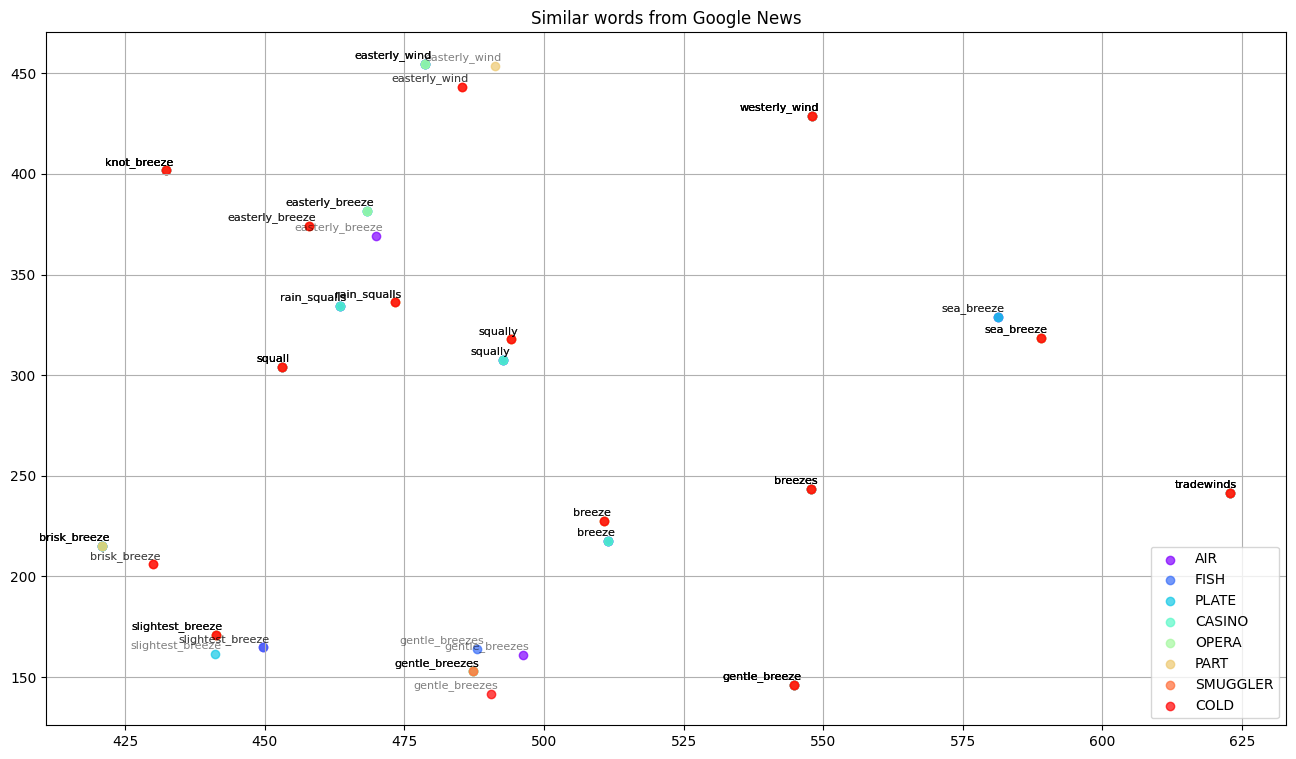

In [14]:
print(word_clusters)

tsne_plot_similar_words('Similar words from Google News', board["Red"], embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [7]:

for label, embeddings, words in zip(board["Red"], embeddings_en_2d, word_clusters):
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    print(words)


['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres', 'chelsea', 'liverpool', 'wenger', 'italian', 'silva']
['juve', 'messi', 'madrid', 'barcelona', 'milan', 'barca', 'italy', 'man_utd', 'rafa', 'torres

In [ ]:
generate_clue(board["Red"])

TypeError: list indices must be integers or slices, not str

In [ ]:
import itertools
for i in itertools.combinations(board["Red"], 3):
  print(list(i))

['BUGLE', 'LINE', 'EYE']
['BUGLE', 'LINE', 'HELICOPTER']
['BUGLE', 'LINE', 'PENGUIN']
['BUGLE', 'LINE', 'STATE']
['BUGLE', 'LINE', 'DOCTOR']
['BUGLE', 'LINE', 'LAP']
['BUGLE', 'EYE', 'HELICOPTER']
['BUGLE', 'EYE', 'PENGUIN']
['BUGLE', 'EYE', 'STATE']
['BUGLE', 'EYE', 'DOCTOR']
['BUGLE', 'EYE', 'LAP']
['BUGLE', 'HELICOPTER', 'PENGUIN']
['BUGLE', 'HELICOPTER', 'STATE']
['BUGLE', 'HELICOPTER', 'DOCTOR']
['BUGLE', 'HELICOPTER', 'LAP']
['BUGLE', 'PENGUIN', 'STATE']
['BUGLE', 'PENGUIN', 'DOCTOR']
['BUGLE', 'PENGUIN', 'LAP']
['BUGLE', 'STATE', 'DOCTOR']
['BUGLE', 'STATE', 'LAP']
['BUGLE', 'DOCTOR', 'LAP']
['LINE', 'EYE', 'HELICOPTER']
['LINE', 'EYE', 'PENGUIN']
['LINE', 'EYE', 'STATE']
['LINE', 'EYE', 'DOCTOR']
['LINE', 'EYE', 'LAP']
['LINE', 'HELICOPTER', 'PENGUIN']
['LINE', 'HELICOPTER', 'STATE']
['LINE', 'HELICOPTER', 'DOCTOR']
['LINE', 'HELICOPTER', 'LAP']
['LINE', 'PENGUIN', 'STATE']
['LINE', 'PENGUIN', 'DOCTOR']
['LINE', 'PENGUIN', 'LAP']
['LINE', 'STATE', 'DOCTOR']
['LINE', 'STATE', 'L

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer, util
transformer = SentenceTransformer('all-MiniLM-L6-v2')


clue = new_cands[1][0]

embeddings1 = transformer.encode(board["Red"], convert_to_tensor=True)
embeddings2 = transformer.encode(clue, convert_to_tensor=True)

final_clues = {}
cosine_scores = util.cos_sim(embeddings1, embeddings2)



for j in range(len(new_cands[0:30])):
  clue = new_cands[j][0]
  embeddings2 = transformer.encode(clue, convert_to_tensor=True)
  for i in range(len(board["Red"])):
    if cosine_scores[i] > 0.14:
      try:
        final_clues[clue] += 1
      except KeyError:
        pass
    #print(clue, board["Red"][i], cosine_scores[i])

print(final_clues)




{}


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
clue, board_word = nlp("interfaces port")
print("Similarity:", clue.similarity(board_word))

Similarity: 0.20674234628677368


<ipython-input-34-aad72750c070>:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print("Similarity:", clue.similarity(board_word))


In [ ]:
from sematch.semantic.similarity import WordNetSimilarity
wns = WordNetSimilarity()
wns.word_similarity('dog', 'cat', 'li')

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (sparql.py, line 36)

In [ ]:
candidate_words = []
for word in board["Red"]:
  print(word)
  neighbors = model.most_similar(positive=board["Red"], negative=board["Blue"] + [board['Assasin']], topn=15)
  neighbors = parse_suggestions(neighbors)
  candidate_words.extend(neighbors)


CHAIR


KeyError: "Key 'TRUNK' not present in vocabulary"

In [ ]:



#synonyms = [i.lemmas() for i in syn]
syn_dict = {}
def generate_synonyms(word):
  synonyms = []
  altered_syn = []
  for syn in wordnet.synsets(word,pos="n"):
      for i in syn.lemmas():
          synonyms.append(i.name().lower())
  for i in synonyms:
    if word.lower() in i or i in word.lower() or "_" in i:
      continue
    else:
      altered_syn.append(i)
  return set(altered_syn)

generate_synonyms("")
#print("capital" in "working_capital")




set()

In [ ]:
print(board)
syn_set = wn.synonyms(board["Red"][0])
print(syn_set[0][0])


{'Red': ['PENGUIN', 'SHOE', 'FIGURE', 'SOUL', 'COMIC', 'CARD', 'BLOCK', 'MOUSE'], 'Blue': ['MASS', 'LEPRECHAUN', 'MAMMOTH', 'CELL', 'GLOVE', 'LITTER', 'LION'], 'Civillian': ['EAGLE', 'ROBIN', 'KETCHUP', 'SPINE', 'LEAD', 'GRACE', 'SHAKESPEARE', 'MATCH', 'HAM'], 'Assasin': 'BALL'}
penguin


##Refactoring agent code

In [ ]:
import itertools
class Agent:
  def __init__(self, board):
    self.model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

    nltk.download('wordnet')
    self.past_clues = []

  def generate_clue(self, board):
    new_cands = get_neighbors(board)
    final_clues = get_clue(new_cands)
    clue = final_clues.pop(0)
    i = 0

    #try to give different clues each time
    while clue in past_clues and i < len(options):
      i += 1
      clue = final_clues.pop(i)
      past_clues.append(clue)

    return clue


  def get_neighbors(self, board, n_words=15):
    candidate_words = []
    new_cands = []
    syn_dict = {}

    # get neighbors for individual words

    for word in board["Red"]:
      synonyms = generate_synonyms(word)
      syn_dict[word] = synonyms

    for words in syn_dict:
      for synonyms in syn_dict[words]:

        try:
          neighbors = self.model.most_similar([synonyms], topn=n_words)
          candidate_words.extend(neighbors)
        except KeyError:
          pass

    for word, score in candidate_words:
      if any(not c.isalnum() for c in word) or word.upper() in board["Red"]:
        continue
      else:
        new_cands.append((word.lower(), score))


    return sorted(list(set((new_cands))), key=lambda x: x[1], reverse = True)


  def generate_synonyms(self, word):
    synonyms = []
    altered_syn = []
    for syn in wordnet.synsets(word):
        for i in syn.lemmas():
            synonyms.append(i.name().lower())
    for i in synonyms:
      if word.lower() in i or i in word.lower() or "_" in i or "-" in i:
        continue
      else:
        altered_syn.append(i)
    return list(set(altered_syn))

  def get_clue(new_cands):

    final_clues = []
    for word, score in new_cands:
      if score >= 0.90:
        final_clues.append((word, 3))
      elif score <= 0.88 and score >= 0.83:
        final_clues.append((word, 2))
      elif score <= 0.83:
        final_clues.append((word,1))

    return final_clues



In [ ]:
import numpy as np
import random

#import pdb
import copy

class Game:
    def __init__(self, words_file):
      self.words_file = words_file
      def gen_board(words_file):
          f = open(words_file, "r")
          board = {}
          temp_array = f.read().splitlines()
          random.shuffle(temp_array)

          board["Red"] = temp_array[:8]
          board["Blue"] = temp_array[8:15]
          board["Civillian"] = temp_array[15:24]
          board["Assasin"]= [temp_array[24]]
          return board

      self.board = gen_board(self.words_file)
      print(self.board)
      self.player = 'red'
      self.blue = self.board["Blue"]
      self.red = self.board["Red"]
      #print(self.red)
      self.assassin = self.board["Assasin"]
      self.neutral = self.board["Civillian"]
      ###agent is red
      self.spymaster = Agent(self.board)
      if self.player == 'blue':
          self.turn_toggle = True
      else:
          self.turn_toggle = False
      return

    #executes the game
    def execute(self):
        print('Let\'s play Codenames')
        print('Your color is: ' + self.player)
        print('the board is:')

        self.show_board()
        while self.blue and self.red and self.assassin:
            if self.turn_toggle:
                print('It\'s your turn; type \"PASS\" to end your turn.')
                self.show_board()
                self.turn()
            else:
                print('It\'s the computer\'s turn:')
                self.opp_turn()
                print('the computer has gone.')

            self.turn_toggle = not self.turn_toggle

        if not self.red:
            print('Red identified all their agents!! They win!!')
        elif not self.blue:
            print('Blue identified all their agents!! They win!!')
        else:
            print('Assassin!! Game over!  ', end = '')
            if self.turn_toggle:
                print('You win!!')
            else:
                print('Computer wins!')
        self.show_board()

    #shows the game board as a dictionary
    def show_board(self):
        board = self.red + self.blue + self.assassin + self.neutral
        random.shuffle(board)
        print(board)


    #execute a full turn for the player
    def turn(self):
        print('Spymaster is generating a clue...')
        print(self.board)
        clue = self.spymaster.generate_clue(self.board)
        print("Your clue is: " + clue[0] + ', ' + str(clue[1]))

        num_guesses = clue[1]
        end = False
        i = 0
        word = ''

        while i < num_guesses and not end and word != 'PASS':
            word = self.guess()
            if word == 'PASS':
                return
            if (word not in self.red):
                print('Your guess was incorrect.  Your turn is over.')
                print()
                end = True
            else:
                print('Correct. You have ' + str(num_guesses-i-1) + ' more guess(es).')
            self.remove_word(word)
            i += 1
        return

    #query a guess from the user
    def guess(self):
        query = input('Guess a word: ')
        print(f"q: {query}")
        if query == 'PASS':
            return query
        while (query not in self.red) and (query not in self.blue) and (query not in self.neutral) and (query not in self.assassin):
            query = input('error: query not in game board. Try again: ')
        return query

    #choose words for the opponent
    def opp_turn(self):
        num = np.random.choice([0,1,2,3], p=[0.2, 0.6, 0.1, 0.1])
        if num == 0:
            self.remove_word(np.random.choice(self.neutral + self.assassin))
            for w in np.random.choice(self.blue, size=min(num, len(self.blue)), replace=False):
                self.remove_word(w)

    #removes a word from the game once it's guessed
    def remove_word(self, word):
        if word in self.blue:
            self.board["Blue"] = [i if i != word else 'BLUE' for i in self.board["Blue"]]
            self.blue.remove(word)
        elif word in self.red:
            self.board["Red"] = [i if i != word else 'RED' for i in self.board["Red"]]
            self.red.remove(word)
        elif word in self.neutral:
            self.board["Civillian"] = [i if i != word else 'NEUTRAL' for i in self.board["Civillian"]]
            self.neutral.remove(word)
        elif word in self.assassin:
            self.board["Assasin"] = [i if i != word else 'ASSASSIN' for i in self.board["Assasin"]]
            self.assassin.remove(word)
        return

In [ ]:
game = Game("game_wordpool.txt")
game.execute()

{'Red': ['GROUND', 'WALL', 'PLASTIC', 'DOCTOR', 'GERMANY', 'ROUND', 'BERMUDA', 'CRICKET'], 'Blue': ['SINK', 'TEMPLE', 'BOLT', 'POOL', 'DRILL', 'PYRAMID', 'MILLIONAIRE'], 'Civillian': ['LOG', 'COOK', 'HOSPITAL', 'LEPRECHAUN', 'FORCE', 'IVORY', 'HOTEL', 'SATELLITE', 'DIVER'], 'Assasin': ['SWING']}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's play Codenames
Your color is: red
the board is:
['HOSPITAL', 'FORCE', 'MILLIONAIRE', 'HOTEL', 'ROUND', 'SWING', 'PYRAMID', 'BOLT', 'IVORY', 'LOG', 'DOCTOR', 'COOK', 'BERMUDA', 'POOL', 'GROUND', 'CRICKET', 'SATELLITE', 'DIVER', 'SINK', 'WALL', 'DRILL', 'PLASTIC', 'LEPRECHAUN', 'GERMANY', 'TEMPLE']
It's the computer's turn:
the computer has gone.
It's your turn; type "PASS" to end your turn.
['LOG', 'DOCTOR', 'SATELLITE', 'SWING', 'GERMANY', 'COOK', 'FORCE', 'SINK', 'DIVER', 'WALL', 'PYRAMID', 'ROUND', 'MILLIONAIRE', 'HOSPITAL', 'GROUND', 'POOL', 'DRILL', 'CRICKET', 'BERMUDA', 'IVORY', 'PLASTIC', 'LEPRECHAUN', 'TEMPLE', 'BOLT', 'HOTEL']
Spymaster is generating a clue...
{'Red': ['GROUND', 'WALL', 'PLASTIC', 'DOCTOR', 'GERMANY', 'ROUND', 'BERMUDA', 'CRICKET'], 'Blue': ['SINK', 'TEMPLE', 'BOLT', 'POOL', 'DRILL', 'PYRAMID', 'MILLIONAIRE'], 'Civillian': ['LOG', 'COOK', 'HOSPITAL', 'LEPRECHAUN', 'FORCE', 'IVORY', 'HOTEL', 'SATELLITE', 'DIVER'], 'Assasin': ['SWING']}


AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [ ]:
red = ['LINE', 'CELL', 'SOCK', 'TRACK', 'BELL', 'GROUND', 'POLE', 'TORCH']
red_dict = {'Red': ['TIE', 'SKYSCRAPER', 'MOLE', 'CIRCLE', 'PANTS', 'SPY', 'CONCERT', 'BOOM'], 'Blue': ['CARROT', 'MUG', 'YARD', 'FAIR', 'POINT', 'TABLET', 'WATER'], 'Civillian': ['MOUTH', 'CHICK', 'VACUUM', 'CHEST', 'EAGLE', 'PLASTIC', 'TICK', 'DOG', 'CLIFF'], 'Assasin': 'TAIL'}
print("TIE" in red_dict["Red"])

True


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

with open('game_wordpool.txt', 'r') as f:
    words = [i.strip('\n').lower() for i in f.readlines()]

game = Game(words, Agent)

game.execute()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's play Codenames
Your color is: red
the board is:

   horn        jack             police                 ghost                      pupil             
  genius       spike            change               horseshoe                     palm             
scientist      knife             beat                  hand                       cliff             
  track        sound           concert                 comic                       luck             
   box         dance             pipe                  drill                      center            

It's the computer's turn:
the computer has gone.
It's your turn; type "PASS" to end your turn.

   horn        jack             police                 ghost                      pupil             
  genius       spike            change               horseshoe                     palm             
scientist      knife             beat                 NEUTRAL                     cliff             
  track        sound           concert  

TypeError: WordNetCorpusReader.synonyms() missing 1 required positional argument: 'word'